# Stage 1: Poduct Detection with YOLOv5

---

## Overview

**Objective:** Detect product bounding boxes in shelf images for downstream classification

**Dataset:** SKU-110K Dataset
- 11,762 shelf images from retail environments
- Dense object detection (avg. 147 objects/image)
- Real-world conditions: occlusion, varied scales

**Model:** YOLOv5 (pretrained on COCO dataset)

**Output:** Cropped product regions for Stage 2 classification

**References:**
- Dataset: [SKU-110K GitHub](https://github.com/eg4000/SKU110K_CVPR19)
- Model: [YOLOv5 Ultralytics](https://github.com/ultralytics/yolov5)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics

## Dataset Overview
**SKU-110K** (Stock Keeping Unit - 110K) is a large-scale retail product detection dataset containing densely packed objects in shelf images.

<pre style="font-family: 'Courier New', monospace;">
SKU110K_fixed/
├── images/                           # 11,762 retail shelf images
│   ├── train_*.jpg                  # 8,219 training images
│   ├── val_*.jpg                    # 588 validation images
│   └── test_*.jpg                   # 2,955 test images
├── annotations/
│   ├── annotations_train.csv        # Training set bounding boxes
│   ├── annotations_val.csv          # Validation set bounding boxes
│   ├── annotations_test.csv         # Test set bounding boxes
│   └── readme.txt                   # Dataset documentation
└── LICENSE.txt                       # Dataset license
</pre>

## Key Characteristics
- **Domain**: Retail product detection in store shelves
- **Total Images**: 11,762 high-resolution images
- **Total Annotations**: ~1.7 million bounding boxes
- **Challenge**: Extreme object density (avg ~147 objects per image)
- **Object Class**: Single class - "Product" (all retail items)

## Annotation Format (CSV Files)
Each row represents one bounding box with columns:
- `image_name`: Image filename
- `x1, y1, x2, y2`: Bounding box coordinates (top-left, bottom-right)
- `class`: Object class (always "object" in this dataset)
- `image_width, image_height`: Original image dimensions

In [ ]:
!tar -xzf "/content/drive/MyDrive/Deep Learning Project/SKU110K_fixed.tar.gz" \
    -C "/content/drive/MyDrive/Deep Learning Project/" \
    SKU110K_fixed/annotations/annotations_train.csv \
    SKU110K_fixed/annotations/annotations_val.csv \
    SKU110K_fixed/annotations/annotations_test.csv

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

base = '/content/drive/MyDrive/Deep Learning Project/SKU110K_fixed/annotations'

columns = ['image_name', 'x1', 'y1', 'x2', 'y2', 'class', 'image_width', 'image_height']

train_df = pd.read_csv(f'{base}/annotations_train.csv', names=columns)
val_df = pd.read_csv(f'{base}/annotations_val.csv', names=columns)
test_df = pd.read_csv(f'{base}/annotations_test.csv', names=columns)

# Train dataset analysis
print("\n" + "=" * 80)
print("TRAIN DATASET DETAILED ANALYSIS")
print("=" * 80)

print(train_df.head())
print(train_df.info())
print(train_df.describe())

# Validation dataset analysis
print("\n" + "=" * 80)
print("VALIDATION DATASET DETAILED ANALYSIS")
print("=" * 80)

print(val_df.head())
print(val_df.info())
print(val_df.describe())

# Test dataset analysis
print("\n" + "=" * 80)
print("TEST DATASET DETAILED ANALYSIS")
print("=" * 80)

print(test_df.head())
print(test_df.info())
print(test_df.describe())


TRAIN DATASET DETAILED ANALYSIS
    image_name    x1    y1    x2    y2   class  image_width  image_height
0  train_0.jpg   208   537   422   814  object         3024          3024
1  train_0.jpg  1268  1923  1365  2209  object         3024          3024
2  train_0.jpg  1135  2074  1261  2166  object         3024          3024
3  train_0.jpg  1045  2085  1122  2258  object         3024          3024
4  train_0.jpg   976  2036  1040  2177  object         3024          3024
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208482 entries, 0 to 1208481
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   image_name    1208482 non-null  object
 1   x1            1208482 non-null  int64 
 2   y1            1208482 non-null  int64 
 3   x2            1208482 non-null  int64 
 4   y2            1208482 non-null  int64 
 5   class         1208482 non-null  object
 6   image_width   1208482 non-null  int64 
 7   image_heig

SKU-110K DATASET OVERVIEW
Train: 8,219 images, 1,208,482 bounding boxes
Val:   588 images, 90,968 bounding boxes
Test:  2,936 images, 431,546 bounding boxes

BOUNDING BOX ANALYSIS

--- Boxes Per Image Statistics ---
Average boxes per image: 147.04
Median boxes per image: 138
Min boxes per image: 1
Max boxes per image: 576
Std boxes per image: 42.76


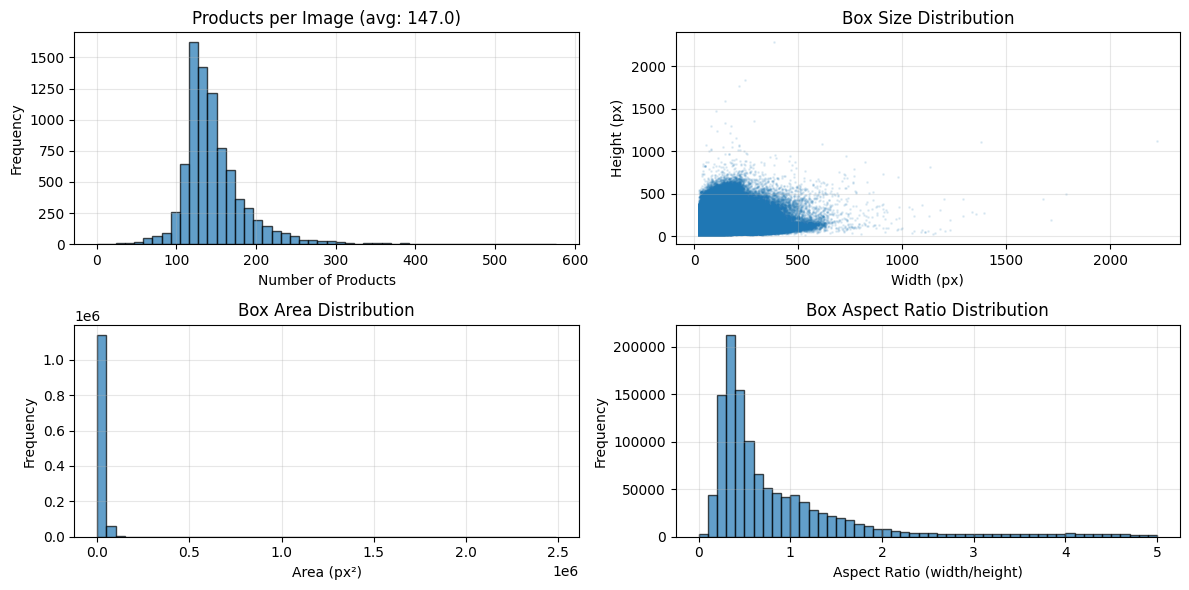

In [6]:
# Dataset overview
print("=" * 80)
print("SKU-110K DATASET OVERVIEW")
print("=" * 80)

print(f"Train: {train_df['image_name'].nunique():,} images, {len(train_df):,} bounding boxes")
print(f"Val:   {val_df['image_name'].nunique():,} images, {len(val_df):,} bounding boxes")
print(f"Test:  {test_df['image_name'].nunique():,} images, {len(test_df):,} bounding boxes")

# Bounding box analysis
print("\n" + "=" * 80)
print("BOUNDING BOX ANALYSIS")
print("=" * 80)

train_df['box_width'] = train_df['x2'] - train_df['x1']
train_df['box_height'] = train_df['y2'] - train_df['y1']
train_df['box_area'] = train_df['box_width'] * train_df['box_height']
train_df['aspect_ratio'] = train_df['box_width'] / train_df['box_height']

# Boxes per image statistics
boxes_per_img = train_df.groupby('image_name').size()
print("\n--- Boxes Per Image Statistics ---")
print(f"Average boxes per image: {boxes_per_img.mean():.2f}")
print(f"Median boxes per image: {boxes_per_img.median():.0f}")
print(f"Min boxes per image: {boxes_per_img.min()}")
print(f"Max boxes per image: {boxes_per_img.max()}")
print(f"Std boxes per image: {boxes_per_img.std():.2f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Plot 1: Boxes per image histogram
axes[0, 0].hist(boxes_per_img, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title(f'Products per Image (avg: {boxes_per_img.mean():.1f})')
axes[0, 0].set_xlabel('Number of Products')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(alpha=0.3)

# Plot 2: Box size scatter
axes[0, 1].scatter(train_df['box_width'], train_df['box_height'], alpha=0.1, s=1)
axes[0, 1].set_title('Box Size Distribution')
axes[0, 1].set_xlabel('Width (px)')
axes[0, 1].set_ylabel('Height (px)')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Box area histogram
axes[1, 0].hist(train_df['box_area'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Box Area Distribution')
axes[1, 0].set_xlabel('Area (px²)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(alpha=0.3)

# Plot 4: Box aspect ratio histogram
axes[1, 1].hist(train_df['aspect_ratio'], bins=50, edgecolor='black', alpha=0.7, range=(0, 5))
axes[1, 1].set_title('Box Aspect Ratio Distribution')
axes[1, 1].set_xlabel('Aspect Ratio (width/height)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [4]:
import random
import tarfile
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Sample 2 random train images
random_imgs = random.sample(train_df['image_name'].unique().tolist(), 2)

tar_path = '/content/drive/MyDrive/Deep Learning Project/SKU110K_fixed.tar.gz'
tar = tarfile.open(tar_path, 'r:gz')

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for idx, img_name in enumerate(random_imgs):
    # Extract image from tar
    member = tar.getmember(f'SKU110K_fixed/images/{img_name}')
    f = tar.extractfile(member)
    img = Image.open(f)

    # Get annotations
    img_data = train_df[train_df['image_name'] == img_name]

    # Draw bounding boxes
    draw = ImageDraw.Draw(img)
    for _, row in img_data.iterrows():
        draw.rectangle([row['x1'], row['y1'], row['x2'], row['y2']],
                      outline='red', width=3)

    # Display
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f'{img_name}\n{len(img_data)} products', fontsize=14, fontweight='bold')

tar.close()

# Save visualization
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Deep Learning Project/sku110k_samples.png', dpi=150, bbox_inches='tight')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Model Training: YOLOv5

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
from PIL import Image

# Prepare validation directories
val_img_dir = Path('/content/drive/MyDrive/Deep Learning Project/SKU110K_fixed/images/val')
val_label_dir = Path('/content/drive/MyDrive/Deep Learning Project/SKU110K_fixed/labels/val')
val_img_dir.mkdir(parents=True, exist_ok=True)
val_label_dir.mkdir(parents=True, exist_ok=True)

# Extract validation set
tar_path = '/content/drive/MyDrive/Deep Learning Project/SKU110K_fixed.tar.gz'
tar = tarfile.open(tar_path, 'r:gz')

val_imgs = val_df['image_name'].unique()
processed = 0

for img_name in val_imgs:
    # Skip if already extracted
    if (val_img_dir / img_name).exists() and (val_label_dir / f"{Path(img_name).stem}.txt").exists():
          processed += 1
          continue
    try:
        member = tar.getmember(f'SKU110K_fixed/images/{img_name}')
        f = tar.extractfile(member)

        # Save image
        with open(val_img_dir / img_name, 'wb') as out:
            out.write(f.read())

        # Get annotations
        img_data = val_df[val_df['image_name'] == img_name]
        w = img_data.iloc[0]['image_width']
        h = img_data.iloc[0]['image_height']

        # Convert to YOLO format
        labels = []
        for _, row in img_data.iterrows():
            x_center = ((row['x1'] + row['x2']) / 2) / w
            y_center = ((row['y1'] + row['y2']) / 2) / h
            width = (row['x2'] - row['x1']) / w
            height = (row['y2'] - row['y1']) / h
            labels.append(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

        # Save labels
        (val_label_dir / f"{Path(img_name).stem}.txt").write_text('\n'.join(labels))
        processed += 1

    except Exception as e:
        print(f"Error processing {img_name}: {e}")
        continue

tar.close()

print(f"\nValidation set extracted:")
print(f"  Images: {len(list(val_img_dir.glob('*.jpg')))} files")
print(f"  Labels: {len(list(val_label_dir.glob('*.txt')))} files")
print(f"  Processed: {processed}")


Validation set extracted:
  Images: 588 files
  Labels: 588 files
  Processed: 588


In [7]:
from pathlib import Path
import shutil
import pandas as pd
import tarfile
from ultralytics import YOLO
import random
import json
from concurrent.futures import ThreadPoolExecutor, as_completed
from threading import Lock

# Base directory
base_dir = Path('/content/drive/MyDrive/Deep Learning Project/SKU110K_fixed')

# Training parameters
train_imgs = train_df['image_name'].unique().tolist()
batch_size = 1000
num_batches_total = len(train_imgs) // batch_size + (1 if len(train_imgs) % batch_size > 0 else 0)
num_batches_to_train = 3  # Only train first 3 batches
tar_path = '/content/drive/MyDrive/Deep Learning Project/SKU110K_fixed.tar.gz'

# Generate random batch assignments for ALL images
random.seed(42)  # Fixed seed for reproducibility
random.shuffle(train_imgs)

# Assign ALL images to batches
batch_assignments = {}
for batch_idx in range(num_batches_total):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, len(train_imgs))
    batch_assignments[batch_idx + 1] = {
        'indices': list(range(start_idx, end_idx)),
        'image_names': train_imgs[start_idx:end_idx]
    }

# Save complete batch assignment info
with open(base_dir / 'batch_assignments.json', 'w') as f:
    json.dump(batch_assignments, f, indent=2)

print("=" * 80)
print("BATCH ASSIGNMENT")
print("=" * 80)
print(f"Total images: {len(train_imgs)}")
print(f"Total batches: {num_batches_total}")
print(f"Batches to train: {num_batches_to_train}")
for batch_num, info in batch_assignments.items():
    print(f"Batch {batch_num}: {len(info['image_names'])} images")

# Log file for extracted images
extracted_log_path = base_dir / 'extracted_images.txt'

# Load already extracted images if log exists
extracted_images = set()
if extracted_log_path.exists():
    with open(extracted_log_path, 'r') as f:
        extracted_images = set(line.strip().split(': ')[-1] for line in f if line.strip())

# Thread locks for file operations
tar_lock = Lock()
log_lock = Lock()

def extract_and_process_image(tar_obj, idx, img_name, train_df_local, img_dir, label_dir):
    """Extract and process a single image with its labels"""
    try:
        # Extract image from tar (needs lock for thread safety)
        with tar_lock:
            member = tar_obj.getmember(f'SKU110K_fixed/images/{img_name}')
            f = tar_obj.extractfile(member)
            img_data_bytes = f.read()

        # Save image
        with open(img_dir / img_name, 'wb') as out:
            out.write(img_data_bytes)

        # Get annotations for this image
        img_data = train_df_local[train_df_local['image_name'] == img_name]
        w = img_data.iloc[0]['image_width']
        h = img_data.iloc[0]['image_height']

        # Convert to YOLO format
        labels = []
        for _, row in img_data.iterrows():
            x_center = ((row['x1'] + row['x2']) / 2) / w
            y_center = ((row['y1'] + row['y2']) / 2) / h
            width = (row['x2'] - row['x1']) / w
            height = (row['y2'] - row['y1']) / h
            labels.append(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

        # Save labels
        (label_dir / f"{Path(img_name).stem}.txt").write_text('\n'.join(labels))

        return True, idx, img_name

    except Exception as e:
        print(f"Error processing {img_name}: {e}")
        return False, idx, img_name

model = None
tar = tarfile.open(tar_path, 'r:gz')

# Only train the first num_batches_to_train batches
for batch_num in range(1, num_batches_to_train + 1):
    batch_imgs = batch_assignments[batch_num]['image_names']
    batch_indices = batch_assignments[batch_num]['indices']

    print("\n" + "=" * 80)
    print(f"BATCH {batch_num}/{num_batches_to_train} - {len(batch_imgs)} images")
    print(f"Indices: {batch_indices[0]} to {batch_indices[-1]}")
    print("=" * 80)

    # Create separate directories for each batch
    batch_img_dir = base_dir / f'images/train_batch_{batch_num}'
    batch_label_dir = base_dir / f'labels/train_batch_{batch_num}'
    batch_img_dir.mkdir(parents=True, exist_ok=True)
    batch_label_dir.mkdir(parents=True, exist_ok=True)

    # Filter images that need to be extracted
    to_extract = [(idx, img) for idx, img in zip(batch_indices, batch_imgs)
                  if img not in extracted_images]

    if not to_extract:
        print("All images already extracted, skipping to training...")
    else:
        print(f"Need to extract {len(to_extract)} images...")

        newly_extracted = []

        # Multi-threaded extraction
        max_workers = 8  # Number of parallel threads
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            # Submit all extraction tasks
            futures = {
                executor.submit(extract_and_process_image, tar, idx, img_name, train_df, batch_img_dir, batch_label_dir): (idx, img_name)
                for idx, img_name in to_extract
            }

            # Process completed tasks
            completed = 0
            for future in as_completed(futures):
                success, idx, img_name = future.result()
                if success:
                    newly_extracted.append(f"{idx}: {img_name}")
                    extracted_images.add(img_name)

                completed += 1
                if completed % 100 == 0:
                    print(f"Progress: {completed}/{len(to_extract)} images processed")

        # Batch write to log file to reduce I/O
        if newly_extracted:
            with log_lock:
                with open(extracted_log_path, 'a') as f:
                    f.write('\n'.join(newly_extracted) + '\n')

        print(f"\nBatch {batch_num} extraction complete:")
        print(f"  Newly extracted: {len(newly_extracted)}")

    print(f"  Images in dir: {len(list(batch_img_dir.glob('*.jpg')))} files")
    print(f"  Labels in dir: {len(list(batch_label_dir.glob('*.txt')))} files")

    # Create YAML config for this batch
    yaml_content = f"""train: {batch_img_dir}
val: {base_dir}/images/val
nc: 1
names: ['Product']
"""
    yaml_path = base_dir / f'data_batch_{batch_num}.yaml'
    Path(yaml_path).write_text(yaml_content)

    # Incremental training
    if model is None:
        model = YOLO('yolov5s.pt')
    else:
        prev_best = f'/content/runs/batch_{batch_num-1}/weights/best.pt'
        model = YOLO(prev_best)

    print(f"\nTraining batch {batch_num}...")
    model.train(
        data=str(yaml_path),
        epochs=100,
        imgsz=640,
        batch=8,
        project='/content/runs',
        name=f'batch_{batch_num}',
        exist_ok=True,
        patience=20
    )

    # Save model after each batch
    batch_best = f'/content/runs/batch_{batch_num}/weights/best.pt'
    shutil.copy(batch_best, base_dir / f'sku110k_batch_{batch_num}.pt')
    print(f"Model saved: sku110k_batch_{batch_num}.pt")

tar.close()

# Save final model
final_best = f'/content/runs/batch_{num_batches_to_train}/weights/best.pt'
shutil.copy(final_best, base_dir / 'sku110k_final.pt')

print("\n" + "=" * 80)
print("TRAINING COMPLETE")
print("=" * 80)
print(f"Total extracted images: {len(extracted_images)}")
print(f"Total batches available: {num_batches_total}")
print(f"Batches trained: {num_batches_to_train}")
print("=" * 80)

BATCH ASSIGNMENT
Total images: 8219
Total batches: 9
Batches to train: 3
Batch 1: 1000 images
Batch 2: 1000 images
Batch 3: 1000 images
Batch 4: 1000 images
Batch 5: 1000 images
Batch 6: 1000 images
Batch 7: 1000 images
Batch 8: 1000 images
Batch 9: 219 images

BATCH 1/3 - 1000 images
Indices: 0 to 999
All images already extracted, skipping to training...
  Images in dir: 1000 files
  Labels in dir: 1000 files
PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


Training batch 1...
Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.

# Model Evaluation

In [9]:
import random
import tarfile
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load trained model
model = YOLO('/content/drive/MyDrive/Deep Learning Project/SKU110K_fixed/sku110k_final.pt')

# Sample 2 random test images
random_imgs = random.sample(test_df['image_name'].unique().tolist(), 2)

tar_path = '/content/drive/MyDrive/Deep Learning Project/SKU110K_fixed.tar.gz'
tar = tarfile.open(tar_path, 'r:gz')

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

for idx, img_name in enumerate(random_imgs):
    # Extract image from tar
    member = tar.getmember(f'SKU110K_fixed/images/{img_name}')
    f = tar.extractfile(member)
    img = Image.open(f)

    # Get ground truth annotations
    img_data = test_df[test_df['image_name'] == img_name]

    # Draw ground truth boxes
    img_gt = img.copy()
    draw_gt = ImageDraw.Draw(img_gt)
    for _, row in img_data.iterrows():
        draw_gt.rectangle([row['x1'], row['y1'], row['x2'], row['y2']],
                         outline='green', width=3)

    # Display ground truth
    axes[idx, 0].imshow(img_gt)
    axes[idx, 0].axis('off')
    axes[idx, 0].set_title(f'Ground Truth: {img_name}\n{len(img_data)} products',
                           fontsize=14, fontweight='bold')

    # Save temporary image for prediction
    temp_path = f'/content/temp_{img_name}'
    img.save(temp_path)

    # Run prediction
    results = model.predict(temp_path, conf=0.25, verbose=False)

    # Draw prediction boxes
    img_pred = img.copy()
    draw_pred = ImageDraw.Draw(img_pred)
    for box in results[0].boxes:
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        conf = box.conf[0].cpu().numpy()
        draw_pred.rectangle([x1, y1, x2, y2],
                           outline='red', width=3)

    # Display prediction
    axes[idx, 1].imshow(img_pred)
    axes[idx, 1].axis('off')
    axes[idx, 1].set_title(f'Prediction: {img_name}\n{len(results[0].boxes)} products detected',
                           fontsize=14, fontweight='bold')

tar.close()

# Save visualization
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Deep Learning Project/sku110k_test_comparison.png',
            dpi=150, bbox_inches='tight')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [10]:
import random
import tarfile
import pandas as pd
from pathlib import Path
from ultralytics import YOLO

# Load trained model
model = YOLO('/content/drive/MyDrive/Deep Learning Project/SKU110K_fixed/sku110k_final.pt')

# Sample 50 random test images
random.seed(42)
random_imgs = random.sample(test_df['image_name'].unique().tolist(), 50)

# Prepare prediction directory
pred_dir = Path('/content/drive/MyDrive/Deep Learning Project/SKU110K_fixed/images/pred')
pred_dir.mkdir(parents=True, exist_ok=True)

# Extract images from tar
tar_path = '/content/drive/MyDrive/Deep Learning Project/SKU110K_fixed.tar.gz'
tar = tarfile.open(tar_path, 'r:gz')

print("Extracting 50 test images...")
for img_name in random_imgs:
    member = tar.getmember(f'SKU110K_fixed/images/{img_name}')
    f = tar.extractfile(member)

    # Save image
    with open(pred_dir / img_name, 'wb') as out:
        out.write(f.read())

tar.close()
print(f"Extracted {len(random_imgs)} images to {pred_dir}")

# Run predictions
print("\nRunning predictions...")
predictions = []

for img_name in random_imgs:
    img_path = pred_dir / img_name

    # Run prediction
    results = model.predict(str(img_path), conf=0.25, verbose=False)

    # Get image dimensions
    img_height, img_width = results[0].orig_shape

    # Extract bounding boxes
    for box in results[0].boxes:
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        conf = box.conf[0].cpu().numpy()

        predictions.append({
            'image_name': img_name,
            'x1': float(x1),
            'y1': float(y1),
            'x2': float(x2),
            'y2': float(y2),
            'class': 'object',
            'image_width': img_width,
            'image_height': img_height,
            'confidence': float(conf)
        })

# Create predictions dataframe
pred_df = pd.DataFrame(predictions)

print(f"\nPredictions complete:")
print(f"  Total images: {len(random_imgs)}")
print(f"  Total predictions: {len(pred_df)}")
print(f"  Average predictions per image: {len(pred_df)/len(random_imgs):.2f}")

print("\nPrediction dataframe:")
print(pred_df.head())
print(f"\nShape: {pred_df.shape}")

Extracting 50 test images...
Extracted 50 images to /content/drive/MyDrive/Deep Learning Project/SKU110K_fixed/images/pred

Running predictions...

Predictions complete:
  Total images: 50
  Total predictions: 7990
  Average predictions per image: 159.80

Prediction dataframe:
     image_name          x1          y1          x2           y2   class  \
0  test_713.jpg  293.130157  988.754395  460.720276  1448.012085  object   
1  test_713.jpg  106.500748  991.742981  281.903076  1465.118896  object   
2  test_713.jpg  475.671539  981.222351  635.216736  1429.347656  object   
3  test_713.jpg  648.951355  972.147461  796.954651  1411.723633  object   
4  test_713.jpg  806.565247  968.047791  949.400452  1395.168457  object   

   image_width  image_height  confidence  
0         2448          3264    0.842926  
1         2448          3264    0.841976  
2         2448          3264    0.834142  
3         2448          3264    0.826498  
4         2448          3264    0.825421  

Shape:

In [19]:
pred_df.to_csv('/content/drive/MyDrive/Deep Learning Project/predictions.csv', index=False)
print("pred_df saved")

pred_df saved


In [13]:
import os
from PIL import Image
from pathlib import Path

# Prepare cropped images directory
crop_dir = Path('/content/drive/MyDrive/Deep Learning Project/cropped_predictions')
crop_dir.mkdir(parents=True, exist_ok=True)

pred_dir = Path('/content/drive/MyDrive/Deep Learning Project/SKU110K_fixed/images/pred')

print("Cropping bounding boxes from predicted images...")

cropped_count = 0
margin = 20  # Add margin around bounding box

for _, row in pred_df.iterrows():
    img_name = row['image_name']
    img_path = pred_dir / img_name

    # Open image
    img = Image.open(img_path)

    # Get bounding box coordinates with margin
    x1 = max(0, int(row['x1']) - margin)
    y1 = max(0, int(row['y1']) - margin)
    x2 = min(img.width, int(row['x2']) + margin)
    y2 = min(img.height, int(row['y2']) + margin)

    # Crop image
    cropped = img.crop((x1, y1, x2, y2))

    # Generate crop filename
    img_stem = Path(img_name).stem
    crop_filename = f"{img_stem}_box_{cropped_count:04d}.jpg"

    # Save cropped image
    cropped.save(crop_dir / crop_filename, quality=95)

    cropped_count += 1

    if cropped_count % 100 == 0:
        print(f"  Cropped: {cropped_count} boxes")

print(f"\nCropping complete:")
print(f"  Total cropped boxes: {cropped_count}")
print(f"  Saved to: {crop_dir}")

Cropping bounding boxes from predicted images...
  Cropped: 100 boxes
  Cropped: 200 boxes
  Cropped: 300 boxes
  Cropped: 400 boxes
  Cropped: 500 boxes
  Cropped: 600 boxes
  Cropped: 700 boxes
  Cropped: 800 boxes
  Cropped: 900 boxes
  Cropped: 1000 boxes
  Cropped: 1100 boxes
  Cropped: 1200 boxes
  Cropped: 1300 boxes
  Cropped: 1400 boxes
  Cropped: 1500 boxes
  Cropped: 1600 boxes
  Cropped: 1700 boxes
  Cropped: 1800 boxes
  Cropped: 1900 boxes
  Cropped: 2000 boxes
  Cropped: 2100 boxes
  Cropped: 2200 boxes
  Cropped: 2300 boxes
  Cropped: 2400 boxes
  Cropped: 2500 boxes
  Cropped: 2600 boxes
  Cropped: 2700 boxes
  Cropped: 2800 boxes
  Cropped: 2900 boxes
  Cropped: 3000 boxes
  Cropped: 3100 boxes
  Cropped: 3200 boxes
  Cropped: 3300 boxes
  Cropped: 3400 boxes
  Cropped: 3500 boxes
  Cropped: 3600 boxes
  Cropped: 3700 boxes
  Cropped: 3800 boxes
  Cropped: 3900 boxes
  Cropped: 4000 boxes
  Cropped: 4100 boxes
  Cropped: 4200 boxes
  Cropped: 4300 boxes
  Cropped: 440

## Summary

### Detection Performance

**Final Metrics:**
- Precision: 89.6%, Recall: 81.8%
- mAP@0.5: 88.9%, mAP@0.5:0.95: 56.2%
- Speed: 3.6ms inference per image

**Training:**
- YOLOv5s (9.1M parameters)
- 117 total epochs across 3 incremental batches
- cls_loss: 2.211 → 0.593 (73% reduction)
- mAP@0.5: 56.6% → 88.9% (+32.3%)

### Key Observations

**Dense Detection Challenge:**
- 147 products/image average (max: 576)
- Single-class "object" detection only
- 7% over-detection rate (160 pred vs 147 avg truth)

**Training Behavior:**
- Strong initial learning (Run 1: 69 epochs)
- Diminishing returns (Run 2-3: early stopping)
- High starting mAP (56.6% epoch 1) from pretrained weights

### Output for Pipeline

**Generated Assets:**
- 7,990 cropped product regions from 50 test images
- Average 159.8 crops per shelf image
- Bounding box CSV with coordinates and confidence (avg 0.83)
- Model weights: `sku110k_batch_3.pt` (18.5MB)

**Integration Limitations:**
- Detection trained on SKU-110K shelf images
- Classification trained on Grocery Store dataset
- Different product distributions and feature spaces
- No product type labels from detection stage
- Expected degraded performance on cropped regions

### Future Improvements

- Unified dataset with consistent product labels
- NMS parameter tuning to reduce over-detection
- Multi-class detection for product categories
- Address 81.8% recall (18% missed products)